In [178]:
from utils_v1 import *


In [179]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    MultipleDates,
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [180]:
# dataset = ParaDeforestationTime()
addPastDeforestationInput = True

dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	
# dataset = MTMultipleDates(dates = [2019, 2020], # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]
# dataset = Para()
if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 10

training = False
save_probabilities = True
loadInference = True
if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58
		# exp = 63
		# exp = 52
		# exp = 64
		# exp = 66
		exp = 66
		exp = 68
		
		# =============
		# exp = 72 # train 2015-2018
		# exp = 69 # train 2016-2018
		# exp = 70 # train 2017-2018
		
		# train 2018-2019. test 2018-2019
		# exp = 39 # old 
		exp = 76 # 88.4 mAP
		# exp = 71 # 89.5 mAP

		# =============
		
		### exp = 73
		# exp = 71
		# exp = 61

		exp = 77 # good?
		# exp = 78 # good but too short?

		exp = 90 # good result. label ok. f1 84.4
	if type(dataset) == MTDeforestationTime:
		exp = 28
	if type(dataset) == MTMultipleDates:
		exp = 73 # train 2018-2019
		# exp = 74 # train 2016-2019
		# exp = 75 # train 2017-2019
		
		exp = 78 # 2019-2020

		# exp = 88 adds project past deforestation to label
		exp = 89 # ok label. so so result
		exp = 91 # ok label. Good result. 81.8 F1
else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 92

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [181]:
exp

91

In [182]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [183]:
# ic(type(dataset), exp, dataset.dates)


In [184]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]


In [185]:
# np.save('label_not_independent.npy', label_mask)


In [186]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [187]:
label_mask.dtype

dtype('uint8')

In [188]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [189]:
label_mask.dtype

dtype('uint8')

In [190]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)


In [191]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.07692308, 0.15384616, 0.23076925, 0.30769232,
        0.3846154 , 0.4615385 , 0.53846157, 0.61538464, 0.6923077 ,
        0.7692308 , 0.84615386, 0.923077  , 1.        ], dtype=float32),
 array([112618766,   2096062,   1054083,   1098901,   1007787,    876898,
           648966,    708581,    287191,    313901,    338545,    240796,
          1332783,  52380640], dtype=int64))

(-0.5, 10419.5, 16794.5, -0.5)

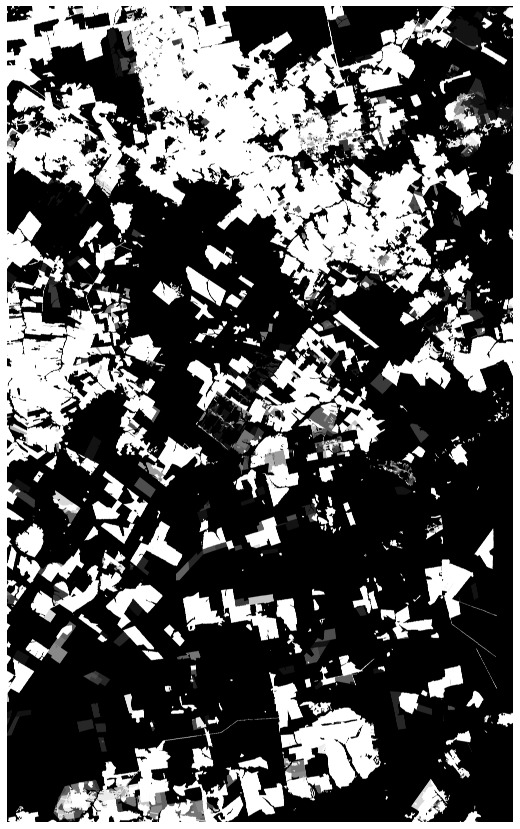

In [192]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [193]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (16795, 10420, 21)
ic| channels: 21


21

In [194]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [195]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


ic| im_idx_row.shape: (16795, 10420, 1)
    im_idx_col.shape: (16795, 10420, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (16795, 10420, 2), im_idx.dtype: dtype('uint16')


In [196]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

ic| coords.shape: (439, 271, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (118969, 2), coords.dtype: dtype('uint16')
ic| coords_train.shape: (54516, 3), coords_val.shape: (13175, 3)


In [197]:
label_mask.shape

(16795, 10420, 1)

(-0.5, 10419.5, 16794.5, -0.5)

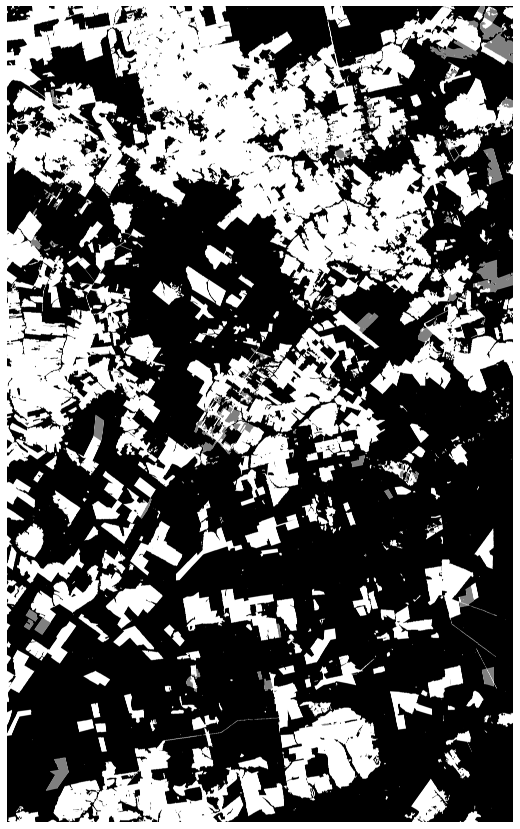

In [198]:

plt.figure(figsize=(15,15))
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [199]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [200]:
if training == True:
    print(coords_train)

[[    0  2090     0]
 [    0  2128     0]
 [    0  2166     0]
 ...
 [16644  8132     0]
 [16644  8170     0]
 [16644  8208     0]]


In [201]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


training samples:  (3403, 3) validation samples:  (610, 3)


In [202]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [203]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [204]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [205]:
inputSnipShow = False

In [206]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [207]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [208]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [209]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [210]:
inputSnipShow = False
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [211]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [212]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [213]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [214]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [215]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/MT/exp91'

In [216]:
channels

21

In [217]:
image_stack.shape

(16795, 10420, 21)

In [218]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model, history

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

time:  0


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (SpatialDropout2D)    (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
____________________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


319/319 [==============================] - 31s 92ms/step - loss: 0.0870 - accuracy: 0.8042 - val_loss: 0.0285 - val_accuracy: 0.9425

Epoch 00001: val_loss improved from inf to 0.02850, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp91/models\resunet_0.h5
Epoch 2/100
  1/319 [..............................] - ETA: 20s - loss: 0.0670 - accuracy: 0.8685

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


319/319 [==============================] - 28s 88ms/step - loss: 0.0616 - accuracy: 0.8860 - val_loss: 0.0197 - val_accuracy: 0.9561

Epoch 00002: val_loss improved from 0.02850 to 0.01968, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp91/models\resunet_0.h5
Epoch 3/100
319/319 [==============================] - 28s 88ms/step - loss: 0.0564 - accuracy: 0.8996 - val_loss: 0.0198 - val_accuracy: 0.9576

Epoch 00003: val_loss did not improve from 0.01968
Epoch 4/100
319/319 [==============================] - 28s 87ms/step - loss: 0.0525 - accuracy: 0.9060 - val_loss: 0.0169 - val_accuracy: 0.9623

Epoch 00004: val_loss improved from 0.01968 to 0.01686, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp91/models\resunet_0.h5
Epoch 5/100
319/319 [==============================] - 28s 88ms/step - loss: 0.0504 - accuracy: 0.9095 - val_loss: 0.0177 - val_accuracy: 0.9617

Epoch 00005: val_loss did not improve from 0.01686
Epoch 6/100
319/319 [===============

In [219]:
image_stack.shape

(16795, 10420, 21)

In [220]:
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [221]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [222]:
image_stack.shape

(16795, 10420, 21)

In [223]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-5.0 -12.0


In [224]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], inference_times), dtype = np.float32)

    new_model = utils_v1.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None)

    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    
            

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)

            
            # Recinstructing predicted map
            start_test = time.time()
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp91/models/resunet_0.h5'


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [225]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [226]:
del image1_pad


In [227]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range(0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




0
1
2
3
4
5
6
7
8
9


In [228]:
useLessInferenceRuns = False
if useLessInferenceRuns == True:

    reducedInferenceRuns = 3
    # prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


In [229]:
prob_rec.shape

(16800, 10432, 10)

In [230]:
prob_rec.shape

(16800, 10432, 10)

In [231]:
mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [232]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 0.0
    np.mean(mean_prob): 0.017334294
    np.max(mean_prob): 0.9999999


(0.0, 0.017334294, 0.9999999)

In [233]:
ic(mean_prob.shape)

ic| mean_prob.shape: (16800, 10432)


(16800, 10432)

In [234]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

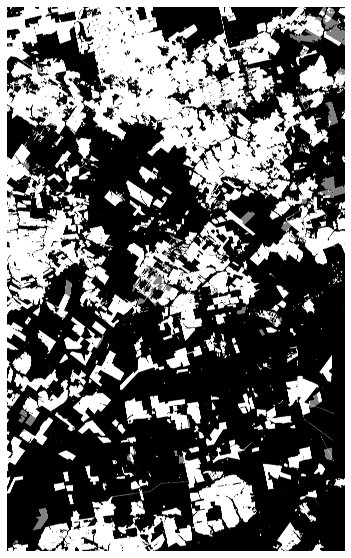

In [235]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [236]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [237]:
mean_prob.shape

(16795, 10420)

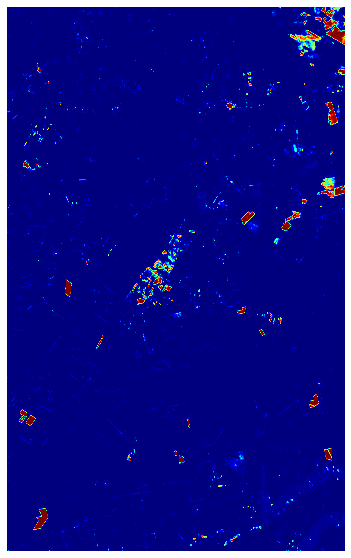

In [238]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [239]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(16795, 10420)


In [240]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))


In [241]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

87.44


In [242]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (16800, 10432, 10)


In [243]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [244]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [245]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [246]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.017330933
    np.max(prob_rec): 1.0
ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [247]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [248]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.010177653
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): -0.0
    np.mean(pred_entropy): 0.01097729
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (16800, 10432)
    pred_entropy_to_show.shape: (16795, 10420)


((16800, 10432), (16795, 10420))

In [249]:
prob_rec.shape

(10, 16800, 10432, 1)

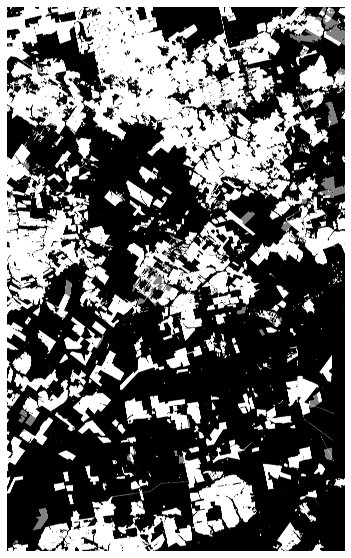

In [250]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [251]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 10419.5, 16794.5, -0.5)

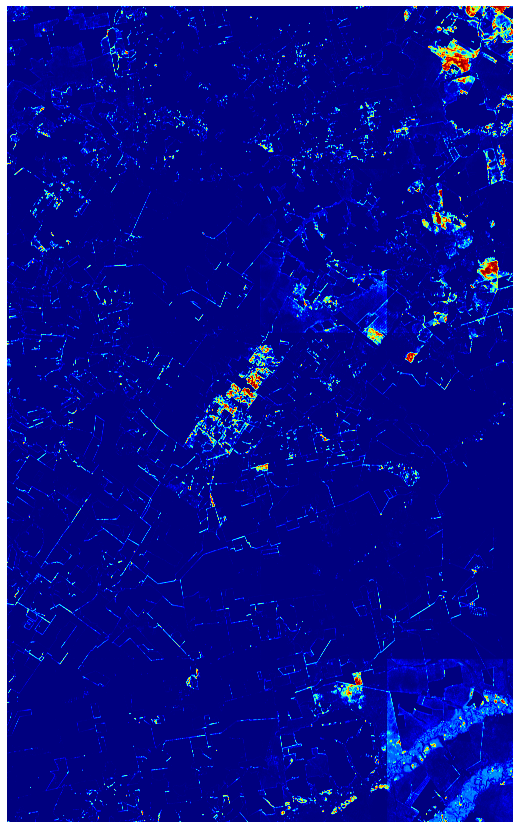

In [252]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

In [253]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (16800, 10432)


(16800, 10432)

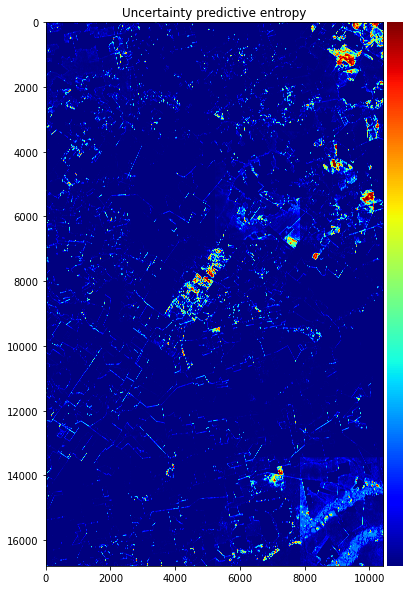

In [254]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [255]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 16800, 10432, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.017330933
    np.max(prob_rec): 1.0


(0.0, 0.017330933, 1.0)

In [256]:

pred_entropy_single = single_experiment_entropy(prob_rec[0])

'''
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


ic| pred_entropy.shape: (16800, 10432)


"\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [257]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([70001560, 84001872, 21000468], dtype=int64))


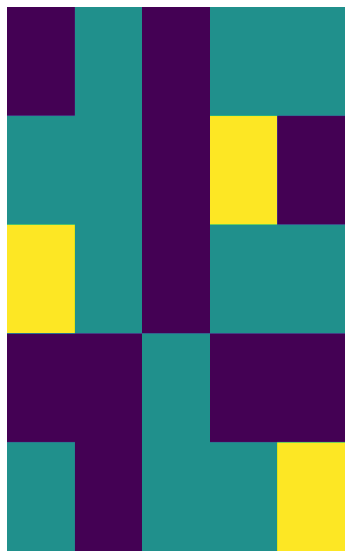

In [258]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [259]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [260]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  2271496, 172732404], dtype=int64))


(array([  0, 255], dtype=uint8), array([  2271496, 172732404], dtype=int64))

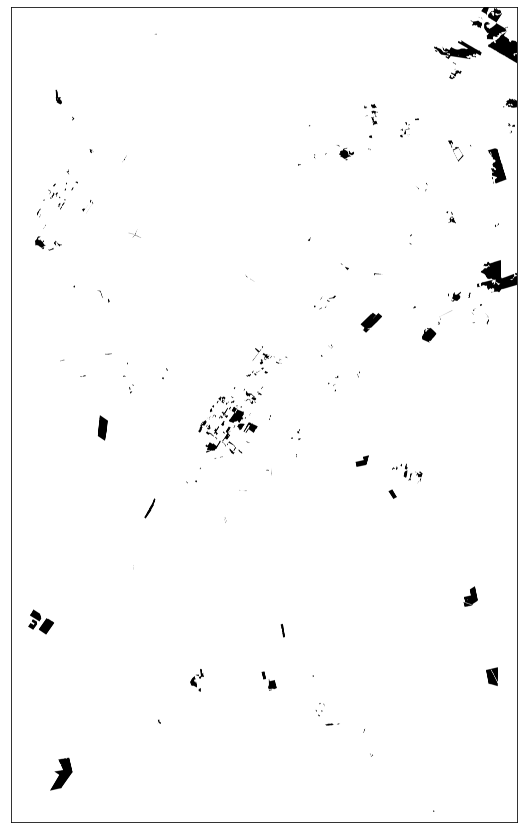

In [261]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [262]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (21000468,)
ic| label_mask_val_valid.shape: (11806421,)


(11806421,)

In [263]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [264]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.771278, F-Score=0.958


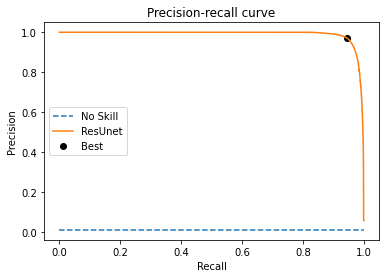

In [265]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [266]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5
# threshold = 0.698

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(16795, 10420)
(array([0., 1.], dtype=float32), array([172534651,   2469249], dtype=int64))


ic| predicted_unpad.shape: (16795, 10420)
    predicted.shape: (16795, 10420)


In [267]:
threshold

0.5

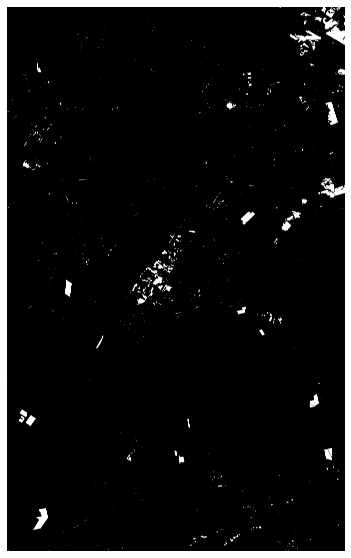

In [268]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [269]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [270]:
# mean_prob_unpad.shape

In [271]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [272]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [273]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [274]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [275]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (16795, 10420)
    label_mask_current_deforestation.shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)
    mean_prob.shape: (16795, 10420)


((16795, 10420),
 (16795, 10420),
 (16795, 10420),
 (16795, 10420),
 (16795, 10420))

In [276]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)


(44657480,)

In [277]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172534651,   2469249], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172683128,   2320772], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174855423,    148477], dtype=int64))
ic| predicted.shape: (16795, 10420), label_mask.shape: (16795, 10420)
ic| predicted_masked.shape: (70001560,)
    label_masked.shape: (70001560,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([43745093,   857294, 25399173], dtype=int64))
ic| predicted_masked.shape: (44602387,)
    label_masked.shape: (44602387,)


In [278]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [279]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 81.83, precision: 80.96, recall: 82.71


(81.83, 80.96, 82.71)

### Metrics for validation set in forest/deforestation detection

In [280]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (16795, 10420)


(16795, 10420)

In [281]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [282]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 95.06
    precision_val: 94.11
    recall_val: 96.03
    mAP_val: 99.05


(95.06, 94.11, 96.03, 99.05)

In [283]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [284]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([174405300,    598600], dtype=int64))


In [285]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (16795, 10420)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   274662, 174405300,    323938], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   274662, 174405300,    323938], dtype=int64))

In [286]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)


((16795, 10420), (16795, 10420))

In [287]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

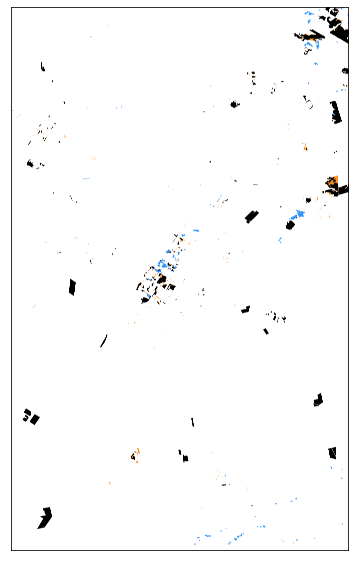

In [288]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


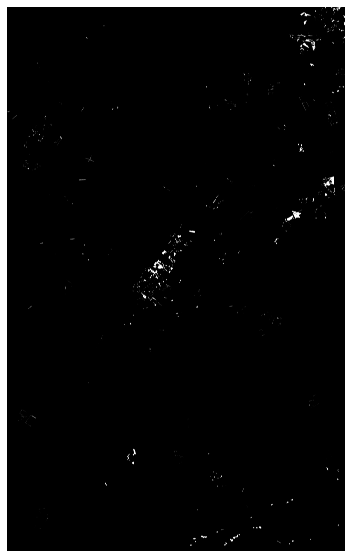

In [289]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [290]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (16795, 10420)
ic| mask_amazon_ts.shape: (16795, 10420)
ic| label_mask_test.shape: (70001560,)
ic| error_mask_test.shape: (44602387,)


(44602387,)

In [291]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [292]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  

ic| pred_entropy.shape: (16800, 10432)
    utils_v1.unpadIm(pred_entropy, npad).shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask_test.shape: (70001560,)


In [293]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [294]:
pred_entropy_single_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_amazon_ts),
        label_mask_test)

pred_entropy_single_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [295]:
# dataset.previewLims1 = np.array([2200, 3200, 6900, 7900])
# dataset.previewLims2 = np.array([500, 1500, 3500, 4500])
# dataset.previewBands = [2, 1, 0] 

In [296]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([11500, 12500,  9000, 10000])
    dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (16795, 10420)


(16795, 10420)

ic| dataset.previewLims1: array([11500, 12500,  9000, 10000])
    dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


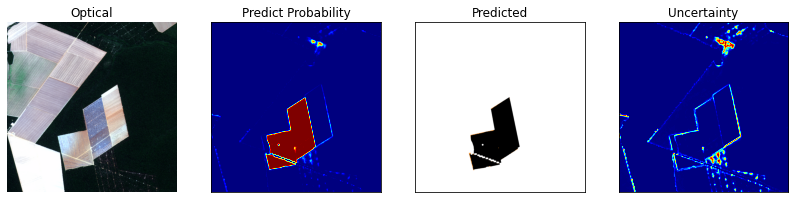

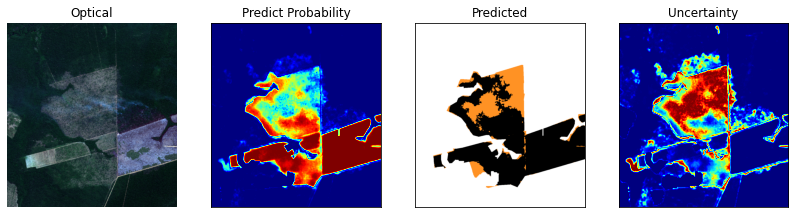

In [297]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [298]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.pred_entropy_single
# predictor = Predictor.MI

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [299]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): -0.0
    np.mean(uncertainty): 0.0136793405
    np.max(uncertainty): 0.36787948
ic| np.min(pred_entropy): -0.0
    np.mean(pred_entropy): 0.01097729
    np.max(pred_entropy): 0.36787948


(-0.0, 0.01097729, 0.36787948)

In [300]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (44602387,), uncertainty.shape: (44602387,)
ic| roc_auc: 0.9649222181697648


0.9649222181697648

Best Threshold=0.103905, G-Mean=0.918


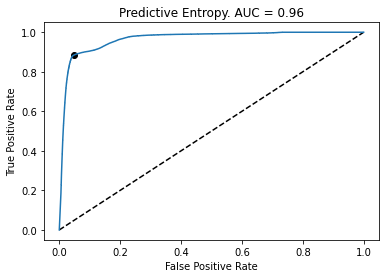

In [301]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [302]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.1039046


In [303]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [304]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [305]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [306]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [307]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [308]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [309]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [310]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [311]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [312]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [313]:
ic(thresholds)

ic| thresholds: array([0.00130282, 0.00130282, 0.00130283, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.00130282, 0.00130282, 0.00130283, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [314]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.276673, F-Score=0.130


C:\Users\jchamorro\AppData\Local\Temp\ipykernel_25524\3129774117.py:1: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


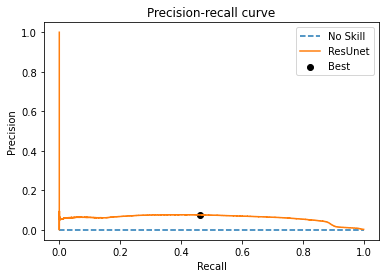

In [315]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [316]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [317]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): -0.0
    np.average(uncertainty): 0.0136793405
    np.max(uncertainty): 0.36787948


(-0.0, 0.0136793405, 0.36787948)

In [318]:
# plt.hist(uncertainty)

In [319]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [320]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (44602387,)
    label_mask_current_deforestation_test.shape: (44602387,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [321]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): -0.0
    np.mean(uncertainty): 0.0136793405
    np.max(uncertainty): 0.36787948


(-0.0, 0.0136793405, 0.36787948)

In [322]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (44602387,)


(44602387,)

In [323]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([43183019,  1419368], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([109888862,   2230453,  62884585], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64))


((array([0, 1], dtype=uint8), array([43183019,  1419368], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([109888862,   2230453,  62884585], dtype=int64)),
 (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64)))

In [324]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.031822691462678895


0.031822691462678895

In [325]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.031822691462678895


0.031822691462678895

In [326]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
        0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (44602387,)
    label_mask_current_deforestation_test.shape: (44602387,)


threshold 0.0025
(34706631,) (34706631,)


ic| label_current_deforestation_test_classified_incorrect.shape: (9895756,)
    predicted_test_classified_incorrect.shape: (9895756,)


cm_correct [[34438453     8522]
 [    1996   257660]]


ic| TP_H + FN_H + FP_H + TN_H: 9895756
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 9895756
    len(label_mask_current_deforestation_test): 44602387


cm_incorrect [[9139929  158189]
 [ 146199  451439]]
[0.96798431 0.99231291 0.30055034 0.22186606 0.74051553 0.75537198]
threshold 0.005
(36953542,) (36953542,)


ic| label_current_deforestation_test_classified_incorrect.shape: (7648845,)
    predicted_test_classified_incorrect.shape: (7648845,)


cm_correct [[36640131    11865]
 [    2252   299294]]


ic| TP_H + FN_H + FP_H + TN_H: 7648845
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 7648845
    len(label_mask_current_deforestation_test): 44602387


cm_incorrect [[6938251  154846]
 [ 145943  409805]]
[0.96186837 0.99253182 0.34911477 0.17148959 0.72576689 0.73739357]
threshold 0.0075
(38107690,) (38107690,)


ic| label_current_deforestation_test_classified_incorrect.shape: (6494697,)
    predicted_test_classified_incorrect.shape: (6494697,)


cm_correct [[37773482    13733]
 [    2670   317805]]


ic| TP_H + FN_H + FP_H + TN_H: 6494697
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 6494697
    len(label_mask_current_deforestation_test): 44602387


cm_incorrect [[5804900  152978]
 [ 145525  391294]]
[0.9585779  0.99166862 0.37070713 0.14561322 0.71893098 0.72891235]
threshold 0.01
(38828547,) (38828547,)


ic| label_current_deforestation_test_classified_incorrect.shape: (5773840,)
    predicted_test_classified_incorrect.shape: (5773840,)


cm_correct [[38478663    15066]
 [    3173   331645]]


ic| TP_H + FN_H + FP_H + TN_H: 5773840
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 5773840
    len(label_mask_current_deforestation_test): 44602387


cm_incorrect [[5099719  151645]
 [ 145022  377454]]
[0.95654594 0.99052321 0.38685095 0.12945137 0.71339012 0.72243318]
threshold 0.015
(39722905,) (39722905,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4879482,)
    predicted_test_classified_incorrect.shape: (4879482,)


cm_correct [[39349483    17230]
 [    4145   352047]]


ic| TP_H + FN_H + FP_H + TN_H: 4879482
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 4879482
    len(label_mask_current_deforestation_test): 44602387


cm_incorrect [[4228899  149481]
 [ 144050  357052]]
[0.95334126 0.98836302 0.41064909 0.10939957 0.70489386 0.71253358]
threshold 0.025
(40701299,) (40701299,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3901088,)
    predicted_test_classified_incorrect.shape: (3901088,)


cm_correct [[40294359    21352]
 [    5503   380085]]


ic| TP_H + FN_H + FP_H + TN_H: 3901088
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 3901088
    len(label_mask_current_deforestation_test): 44602387


cm_incorrect [[3284023  145359]
 [ 142692  329014]]
[0.94681108 0.98572829 0.44335432 0.08746366 0.69357657 0.69749802]
threshold 0.05
(41786888,) (41786888,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2815499,)
    predicted_test_classified_incorrect.shape: (2815499,)


cm_correct [[41322289    30194]
 [    8007   426398]]


ic| TP_H + FN_H + FP_H + TN_H: 2815499
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 2815499
    len(label_mask_current_deforestation_test): 44602387


cm_incorrect [[2256093  136517]
 [ 140188  282701]]
[0.93387094 0.98156789 0.49737663 0.0631244  0.6743532  0.6684993 ]
threshold 0.08
(42415290,) (42415290,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2187097,)
    predicted_test_classified_incorrect.shape: (2187097,)


cm_correct [[41888044    44913]
 [   11123   471210]]


ic| TP_H + FN_H + FP_H + TN_H: 2187097
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 2187097
    len(label_mask_current_deforestation_test): 44602387


cm_incorrect [[1690338  121798]
 [ 137072  237889]]
[0.91298005 0.97693917 0.54964808 0.04903542 0.66137781 0.63443665]
threshold 0.1
(42704229,) (42704229,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1898158,)
    predicted_test_classified_incorrect.shape: (1898158,)


cm_correct [[42130104    62407]
 [   13156   498562]]


ic| TP_H + FN_H + FP_H + TN_H: 1898158
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 1898158
    len(label_mask_current_deforestation_test): 44602387


cm_incorrect [[1448278  104304]
 [ 135039  210537]]
[0.88875143 0.97429053 0.58155312 0.04255732 0.66870897 0.60923502]
threshold 0.15
(43183019,) (43183019,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1419368,)
    predicted_test_classified_incorrect.shape: (1419368,)
ic| TP_H + FN_H + FP_H + TN_H: 1419368
    len

cm_correct [[42520060    87844]
 [   18581   556534]]
cm_incorrect [[1058322   78867]
 [ 129614  152565]]


(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 1419368
    len(label_mask_current_deforestation_test): 44602387


[0.86367629 0.96769168 0.6491752  0.03182269 0.65922172 0.54066745]
threshold 0.2
(43516387,) (43516387,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1086000,)
    predicted_test_classified_incorrect.shape: (1086000,)
ic| TP_H + FN_H + FP_H + TN_H: 1086000
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 1086000
    len(label_mask_current_deforestation_test): 44602387


cm_correct [[42782775   106835]
 [   24796   601981]]
cm_incorrect [[795607  59876]
 [123399 107118]]
[0.84927682 0.96043888 0.70218735 0.02434847 0.6414482  0.4646859 ]
threshold 0.225
(43655506,) (43655506,)


ic| label_current_deforestation_test_classified_incorrect.shape: (946881,)
    predicted_test_classified_incorrect.shape: (946881,)
ic| TP_H + FN_H + FP_H + TN_H: 946881
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 946881
    len(label_mask_current_deforestation_test): 44602387


cm_correct [[42891338   115127]
 [   28159   620882]]
cm_incorrect [[687044  51584]
 [120036  88217]]
[0.84357936 0.95661445 0.72423463 0.02122938 0.63101838 0.42360494]
threshold 0.25
(43785291,) (43785291,)


ic| label_current_deforestation_test_classified_incorrect.shape: (817096,)
    predicted_test_classified_incorrect.shape: (817096,)
ic| TP_H + FN_H + FP_H + TN_H: 817096
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 817096
    len(label_mask_current_deforestation_test): 44602387


cm_correct [[42991437   123417]
 [   32163   638274]]
cm_incorrect [[586945  43294]
 [116032  70825]]
[0.83796973 0.95202681 0.74452172 0.01831956 0.62062409 0.37903316]
threshold 0.27
(43880454,) (43880454,)


ic| label_current_deforestation_test_classified_incorrect.shape: (721933,)
    predicted_test_classified_incorrect.shape: (721933,)
ic| TP_H + FN_H + FP_H + TN_H: 721933
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 721933
    len(label_mask_current_deforestation_test): 44602387


cm_correct [[43062501   130579]
 [   35853   651521]]
cm_incorrect [[515881  36132]
 [112342  57578]]
[0.83304053 0.94784062 0.75997382 0.01618597 0.61442749 0.33885358]
threshold 0.3
(44023595,) (44023595,)


ic| label_current_deforestation_test_classified_incorrect.shape: (578792,)
    predicted_test_classified_incorrect.shape: (578792,)
ic| TP_H + FN_H + FP_H + TN_H: 578792
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 578792
    len(label_mask_current_deforestation_test): 44602387


cm_correct [[43166001   142399]
 [   43017   672178]]
cm_incorrect [[412381  24312]
 [105178  36921]]
[0.82518657 0.93985277 0.78406941 0.0129767  0.60295919 0.2598259 ]
threshold 0.34
(44239129,) (44239129,)


ic| label_current_deforestation_test_classified_incorrect.shape: (363258,)
    predicted_test_classified_incorrect.shape: (363258,)
ic| TP_H + FN_H + FP_H + TN_H: 363258
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 363258
    len(label_mask_current_deforestation_test): 44602387


cm_correct [[43315230   162382]
 [   58192   703325]]
cm_incorrect [[263152   4329]
 [ 90003   5774]]
[0.81242845 0.92358411 0.82040117 0.00814436 0.57151341 0.06028587]
threshold 0.36
(44410622,) (44410622,)


ic| label_current_deforestation_test_classified_incorrect.shape: (191765,)
    predicted_test_classified_incorrect.shape: (191765,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 191765
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 191765
    len(label_mask_current_deforestation_test): 44602387


cm_correct [[43439284   166711]
 [   95528   709099]]
cm_incorrect [[139098      0]
 [ 52667      0]]
[0.80964935 0.88127667 0.82713631 0.00429943        nan 0.        ]
threshold 0.3648794801235199
(44484403,) (44484403,)


ic| label_current_deforestation_test_classified_incorrect.shape: (117984,)
    predicted_test_classified_incorrect.shape: (117984,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 117984
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 117984
    len(label_mask_current_deforestation_test): 44602387


cm_correct [[43493208   166711]
 [  115385   709099]]
cm_incorrect [[85174     0]
 [32810     0]]
[0.80964935 0.86005186 0.82713631 0.00264524        nan 0.        ]
threshold 0.3663794801235199
(44518807,) (44518807,)


ic| label_current_deforestation_test_classified_incorrect.shape: (83580,)
    predicted_test_classified_incorrect.shape: (83580,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 83580
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 83580
    len(label_mask_current_deforestation_test): 44602387


cm_correct [[43518088   166711]
 [  124909   709099]]
cm_incorrect [[60294     0]
 [23286     0]]
[0.80964935 0.85023045 0.82713631 0.00187389        nan 0.        ]


In [327]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (44602387,)
    label_mask_current_deforestation_test.shape: (44602387,)


threshold 0.0025
(44602387,) (44602387,)
cm_audited [[43736571     8522]
 [    1996   855298]]
[0.99013452 0.99767174]
threshold 0.005
(44602387,) (44602387,)
cm_audited [[43733228    11865]
 [    2252   855042]]
[0.98631341 0.99737313]
threshold 0.0075
(44602387,) (44602387,)
cm_audited [[43731360    13733]
 [    2670   854624]]
[0.98418508 0.99688555]
threshold 0.01
(44602387,) (44602387,)
cm_audited [[43730027    15066]
 [    3173   854121]]
[0.98266656 0.99629882]
threshold 0.015
(44602387,) (44602387,)
cm_audited [[43727863    17230]
 [    4145   853149]]
[0.98020403 0.99516502]
threshold 0.025
(44602387,) (44602387,)
cm_audited [[43723741    21352]
 [    5503   851791]]
[0.97554582 0.99358097]
threshold 0.05
(44602387,) (44602387,)
cm_audited [[43714899    30194]
 [    8007   849287]]
[0.96566839 0.99066015]
threshold 0.08
(44602387,) (44602387,)
cm_audited [[43700180    44913]
 [   11123   846171]]
[0.94959734 0.98702545]
threshold 0.1
(44602387,) (44602387,)
cm_audited [[436826

ic| metric_values_audited: array([[0.99013452, 0.99767174],
                                  [0.98631341, 0.99737313],
                                  [0.98418508, 0.99688555],
                                  [0.98266656, 0.99629882],
                                  [0.98020403, 0.99516502],
                                  [0.97554582, 0.99358097],
                                  [0.96566839, 0.99066015],
                                  [0.94959734, 0.98702545],
                                  [0.93115951, 0.98465404],
                                  [0.9051931 , 0.97832599],
                                  [0.88626504, 0.97107643],
                                  [0.87807727, 0.96715363],
                                  [0.8698885 , 0.96248312],
                                  [0.86284007, 0.95817887],
                                  [0.85115232, 0.94982235],
                                  [0.83111315, 0.9321213 ],
                                  [0.820

cm_audited [[43578382   166711]
 [  124909   732385]]
[0.81457931 0.85429853]


In [328]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [329]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [330]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [331]:
save_figures = True

In [332]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

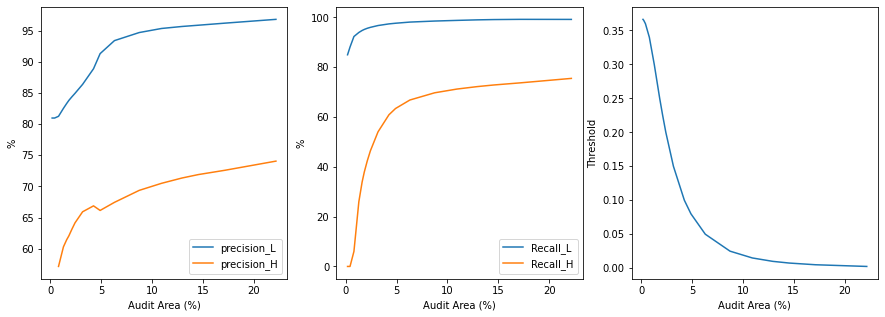

In [333]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [334]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


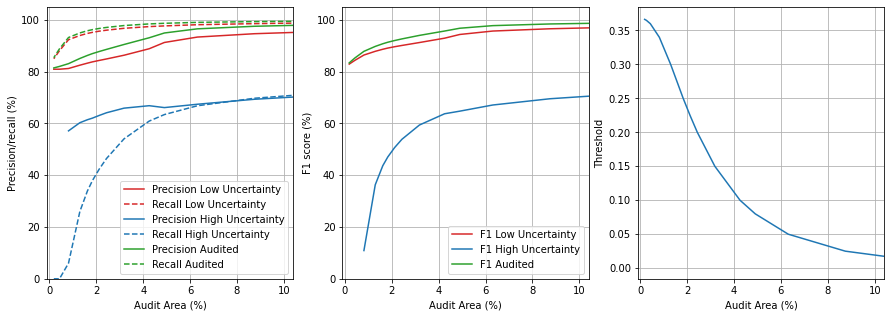

In [335]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [336]:


m

{'precision_L': array([0.96798431, 0.96186837, 0.9585779 , 0.95654594, 0.95334126,
        0.94681108, 0.93387094, 0.91298005, 0.88875143, 0.86367629,
        0.84927682, 0.84357936, 0.83796973, 0.83304053, 0.82518657,
        0.81242845, 0.80964935, 0.80964935, 0.80964935]),
 'recall_L': array([0.99231291, 0.99253182, 0.99166862, 0.99052321, 0.98836302,
        0.98572829, 0.98156789, 0.97693917, 0.97429053, 0.96769168,
        0.96043888, 0.95661445, 0.95202681, 0.94784062, 0.93985277,
        0.92358411, 0.88127667, 0.86005186, 0.85023045]),
 'recall_Ltotal': array([0.30055034, 0.34911477, 0.37070713, 0.38685095, 0.41064909,
        0.44335432, 0.49737663, 0.54964808, 0.58155312, 0.6491752 ,
        0.70218735, 0.72423463, 0.74452172, 0.75997382, 0.78406941,
        0.82040117, 0.82713631, 0.82713631, 0.82713631]),
 'AA': array([0.22186606, 0.17148959, 0.14561322, 0.12945137, 0.10939957,
        0.08746366, 0.0631244 , 0.04903542, 0.04255732, 0.03182269,
        0.02434847, 0.021229

In [337]:
m_audited

{'precision': array([0.99013452, 0.98631341, 0.98418508, 0.98266656, 0.98020403,
        0.97554582, 0.96566839, 0.94959734, 0.93115951, 0.9051931 ,
        0.88626504, 0.87807727, 0.8698885 , 0.86284007, 0.85115232,
        0.83111315, 0.82044682, 0.81652286, 0.81457931]),
 'recall': array([0.99767174, 0.99737313, 0.99688555, 0.99629882, 0.99516502,
        0.99358097, 0.99066015, 0.98702545, 0.98465404, 0.97832599,
        0.97107643, 0.96715363, 0.96248312, 0.95817887, 0.94982235,
        0.9321213 , 0.88857032, 0.8654079 , 0.85429853]),
 'f1': array([0.99388884, 0.99181244, 0.9904946 , 0.98943574, 0.98762787,
        0.9844808 , 0.97800464, 0.96794972, 0.95715992, 0.94033975,
        0.92673438, 0.92046542, 0.91384628, 0.90801376, 0.89778442,
        0.87872407, 0.85315082, 0.84025496, 0.83396626])}

In [338]:

importlib.reload(_metrics)


# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
#threshold_list2 = [0.09] # exp 77 PA 50 runs
# threshold_list2 = [0.085] # exp 77 PA 30 runs
# threshold_list2 = [0.085] # exp 77 PA 10 runs
# threshold_list2 = [0.083] # exp 77 PA 5 runs
threshold_list2 = [0.065] # exp 77 PA 5 runs
threshold_list2 = [0.06] # exp 77 PA 5 runs
threshold_list2 = [0.0825] # exp 77 PA 3 runs


ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (44602387,)
    label_mask_current_deforestation_test.shape: (44602387,)


threshold 0.0825
(42454585,) (42454585,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2147802,)
    predicted_test_classified_incorrect.shape: (2147802,)


cm_correct [[41921975    46478]
 [   11353   474779]]


ic| TP_H + FN_H + FP_H + TN_H: 2147802
    len(label_mask_current_deforestation_test): 44602387
ic| TP_H + FN_H + FP_H + TN_H: 2147802
    len(label_mask_current_deforestation_test): 44602387


cm_incorrect [[1656407  120233]
 [ 136842  234320]]
[0.91083477 0.97664626 0.55381118 0.04815442 0.6608885  0.63131463]
threshold 0.0825
(44602387,) (44602387,)
cm_audited [[43698615    46478]
 [   11353   845941]]
[0.94791908 0.98675717]


In [339]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.04815442]),
         'f1_H': array([0.64576314]),
         'f1_L': array([0.94259318]),
         'precision_H': array([0.6608885]),
         'precision_L': array([0.91083477]),
         'recall_H': array([0.63131463]),
         'recall_L': array([0.97664626]),
         'recall_Ltotal': array([0.55381118])}
ic| m_audited2: {'f1': array([0.96694829]),
                 'precision': array([0.94791908]),
                 'recall': array([0.98675717])}


{'precision': array([0.94791908]),
 'recall': array([0.98675717]),
 'f1': array([0.96694829])}

In [340]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (16795, 10420)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([169320485,   5683415], dtype=int64))


(array([0, 1], dtype=int8), array([169320485,   5683415], dtype=int64))

(-0.5, 10431.5, 16799.5, -0.5)

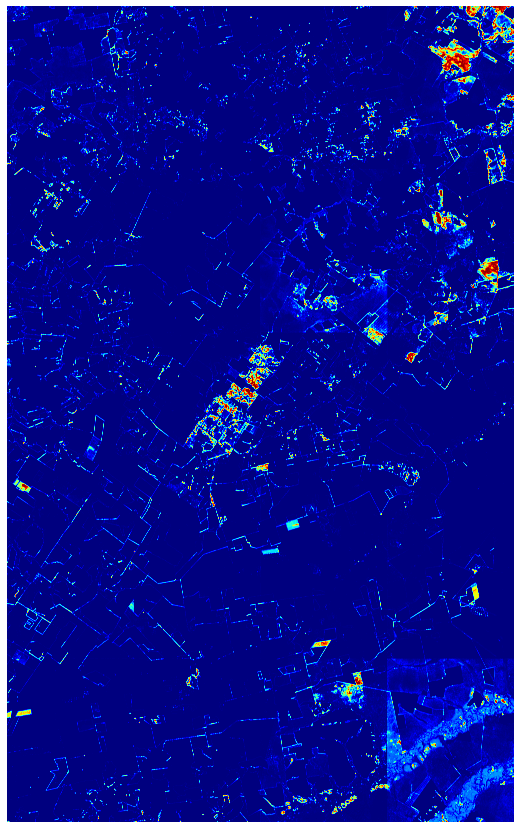

In [341]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy, cmap='jet')
plt.axis('off')


(-0.5, 10419.5, 16794.5, -0.5)

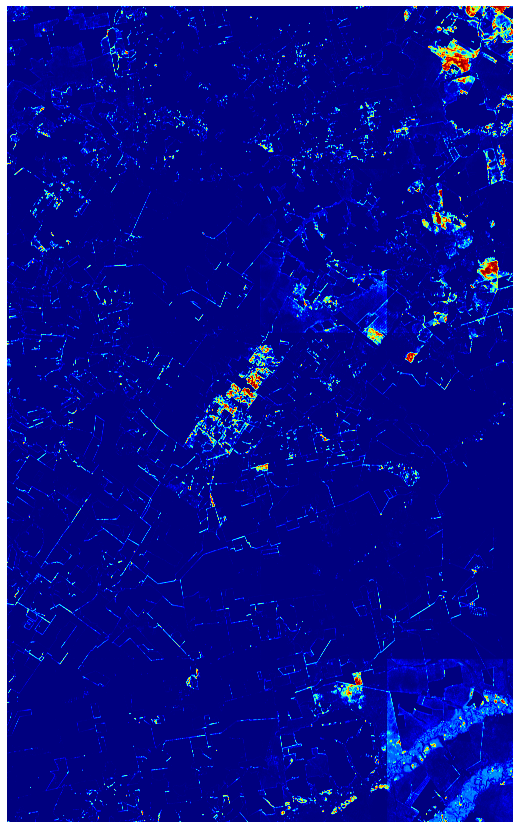

In [342]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 10419.5, 16794.5, -0.5)

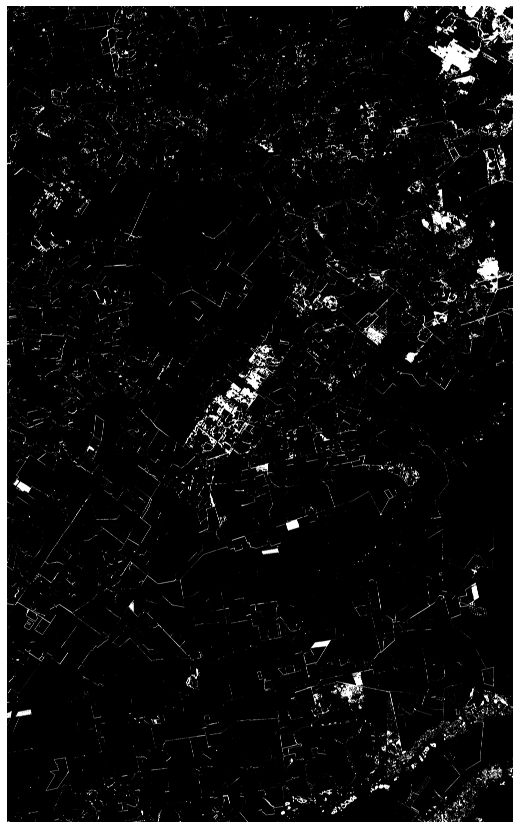

In [343]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [344]:
np.unique(label_mask_val_valid, return_counts=True)

(array([0, 1], dtype=uint8), array([11562693,   243728], dtype=int64))

In [345]:
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(uncertainty_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)



ic| uncertainty_val.shape: (11806421,)
    label_mask_val_valid.shape: (11806421,)


threshold 0.015
(7401877,) (7401877,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4404544,)
    predicted_test_classified_incorrect.shape: (4404544,)


cm_correct [[7210687       0]
 [    274  190916]]


ic| TP_H + FN_H + FP_H + TN_H: 4404544
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 4404544
    len(label_mask_current_deforestation_test): 11806421


cm_incorrect [[4337346   14660]
 [   9406   43132]]
[1.         0.99856687 0.78331583 0.37306344 0.74633167 0.82096768]
threshold 0.025
(8492535,) (8492535,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3313886,)
    predicted_test_classified_incorrect.shape: (3313886,)


cm_correct [[8292975      49]
 [    339  199172]]


ic| TP_H + FN_H + FP_H + TN_H: 3313886
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 3313886
    len(label_mask_current_deforestation_test): 11806421


cm_incorrect [[3255058   14611]
 [   9341   34876]]
[0.99975404 0.99830085 0.81718965 0.28068506 0.70475074 0.78874641]
threshold 0.05
(9614605,) (9614605,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2191816,)
    predicted_test_classified_incorrect.shape: (2191816,)


cm_correct [[9404515     629]
 [    460  209001]]


ic| TP_H + FN_H + FP_H + TN_H: 2191816
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 2191816
    len(label_mask_current_deforestation_test): 11806421


cm_incorrect [[2143518   14031]
 [   9220   25047]]
[0.99699948 0.99780389 0.8575174  0.1856461  0.64094887 0.73093647]
threshold 0.08
(10291884,) (10291884,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1514537,)
    predicted_test_classified_incorrect.shape: (1514537,)
ic| TP_H + FN_H + 

cm_correct [[10074324     1234]
 [     812   215514]]
cm_incorrect [[1473709   13426]
 [   8868   18534]]


FP_H + TN_H: 1514537
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 1514537
    len(label_mask_current_deforestation_test): 11806421


[0.99430675 0.99624641 0.88423981 0.12828079 0.57991239 0.67637399]
threshold 0.1
(11120687,) (11120687,)


ic| label_current_deforestation_test_classified_incorrect.shape: (685734,)
    predicted_test_classified_incorrect.shape: (685734,)
ic| TP_H + FN_H + FP_H + TN_H: 685734
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 685734
    len(label_mask_current_deforestation_test): 11806421


cm_correct [[10899134     1629]
 [    1058   218866]]
cm_incorrect [[648899  13031]
 [  8622  15182]]
[0.99261208 0.99518925 0.89799284 0.05808145 0.53812072 0.63779197]
threshold 0.15
(11452729,) (11452729,)


ic| label_current_deforestation_test_classified_incorrect.shape: (353692,)
    predicted_test_classified_incorrect.shape: (353692,)
ic| TP_H + FN_H + FP_H + TN_H: 353692
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 353692
    len(label_mask_current_deforestation_test): 11806421


cm_correct [[11223273     3175]
 [    1787   224494]]
cm_incorrect [[324760  11485]
 [  7893   9554]]
[0.98605432 0.99210274 0.92108416 0.0299576  0.45410904 0.54760131]
threshold 0.2
(11553174,) (11553174,)


ic| label_current_deforestation_test_classified_incorrect.shape: (253247,)
    predicted_test_classified_incorrect.shape: (253247,)
ic| TP_H + FN_H + FP_H + TN_H: 253247
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 253247
    len(label_mask_current_deforestation_test): 11806421


cm_correct [[11317391     5062]
 [    2700   228021]]
cm_incorrect [[230642   9598]
 [  6980   6027]]
[0.97828241 0.98829755 0.93555521 0.02144994 0.385728   0.46336588]
threshold 0.25
(11623937,) (11623937,)


ic| label_current_deforestation_test_classified_incorrect.shape: (182484,)
    predicted_test_classified_incorrect.shape: (182484,)
ic| TP_H + FN_H + FP_H + TN_H: 182484
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 182484
    len(label_mask_current_deforestation_test): 11806421


cm_correct [[11382575     7510]
 [    3583   230269]]
cm_incorrect [[165458   7150]
 [  6097   3779]]
[0.96841605 0.98467834 0.94477861 0.01545634 0.34577729 0.3826448 ]
threshold 0.27
(11649552,) (11649552,)


ic| label_current_deforestation_test_classified_incorrect.shape: (156869,)
    predicted_test_classified_incorrect.shape: (156869,)
ic| TP_H + FN_H + FP_H + TN_H: 156869
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 156869
    len(label_mask_current_deforestation_test): 11806421


cm_correct [[11405906     8655]
 [    3899   231092]]
cm_incorrect [[142127   6005]
 [  5781   2956]]
[0.96389944 0.98340788 0.94815532 0.01328675 0.3298739  0.33833123]
threshold 0.3
(11685636,) (11685636,)


ic| label_current_deforestation_test_classified_incorrect.shape: (120785,)
    predicted_test_classified_incorrect.shape: (120785,)
ic| TP_H + FN_H + FP_H + TN_H: 120785
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 120785
    len(label_mask_current_deforestation_test): 11806421


cm_correct [[11438176    10681]
 [    4436   232343]]
cm_incorrect [[109857   3979]
 [  5244   1705]]
[0.95604961 0.98126523 0.95328809 0.01023045 0.29996481 0.24535904]
threshold 0.34
(11736864,) (11736864,)


ic| label_current_deforestation_test_classified_incorrect.shape: (69557,)
    predicted_test_classified_incorrect.shape: (69557,)
ic| TP_H + FN_H + FP_H + TN_H: 69557
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 69557
    len(label_mask_current_deforestation_test): 11806421


cm_correct [[11483385    13967]
 [    5706   233806]]
cm_incorrect [[64648   693]
 [ 3974   242]]
[0.94362985 0.97617656 0.95929068 0.00589146 0.25882353 0.05740038]
threshold 0.36
(11772125,) (11772125,)


ic| label_current_deforestation_test_classified_incorrect.shape: (34296,)
    predicted_test_classified_incorrect.shape: (34296,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 34296
    len(label_mask_current_deforestation_test): 11806421
ic| TP_H + FN_H + FP_H + TN_H: 34296
    len(label_mask_current_deforestation_test): 11806421
ic| metrics_values_val: array([[1.        , 0.99856687, 0.78331583, 0.37306344, 0.74633167,
                                0.82096768],
                               [0.99975404, 0.99830085, 0.81718965, 0.28068506, 0.70475074,
                                0.78874641],
                               [0.99699948, 0.99780389, 0.8575174 , 0.1856461 , 0.64094887,
                                0.73093647],
                               [0.99430675, 0.99624641, 0.88423981, 0.12828079, 0.57991239,
                         

cm_correct [[11515905    14660]
 [    7512   234048]]
cm_incorrect [[32128     0]
 [ 2168     0]]
[0.94105537 0.96890214 0.96028359 0.00290486        nan 0.        ]


In [346]:
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False

In [347]:
threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


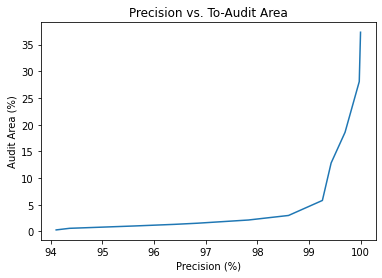

In [348]:
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')

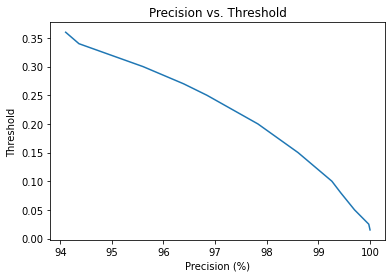

In [349]:
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')

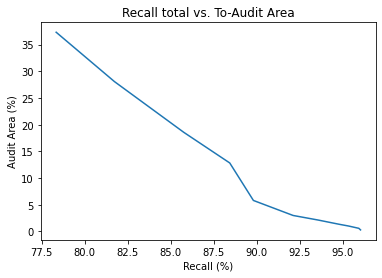

In [350]:
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')

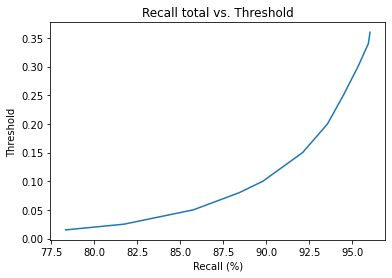

In [351]:
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')

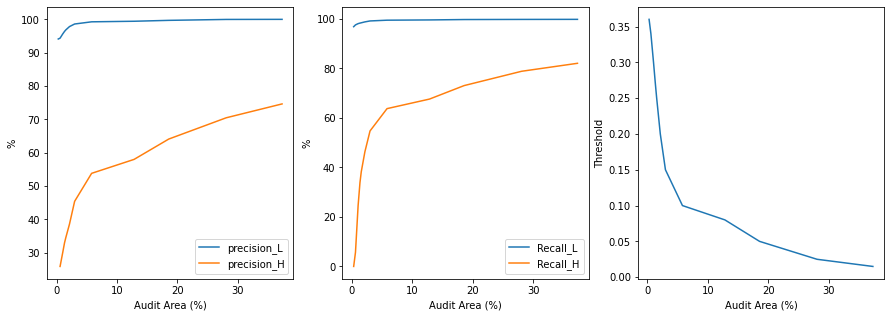

In [352]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')

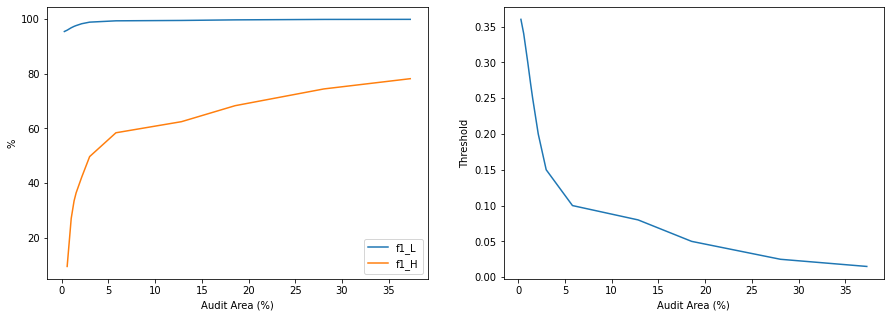

In [353]:
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')

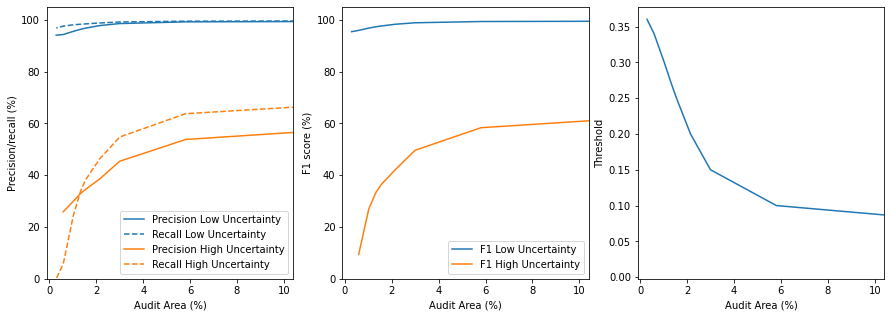

In [354]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')